In [1]:
## doing the necessary imports
import pandas as pd
import numpy as np
import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# Importing data files

In [2]:
grades = pd.read_csv('Grades.csv')
pd.set_option('display.max_columns', None)
grades.head()

,Seat No.,PH-121,HS-101,CY-105,HS-105/12,MT-111,CS-105,CS-106,EL-102,EE-119,ME-107,CS-107,HS-205/20,MT-222,EE-222,MT-224,CS-210,CS-211,CS-203,CS-214,EE-217,CS-212,CS-215,MT-331,EF-303,HS-304,CS-301,CS-302,TC-383,MT-442,EL-332,CS-318,CS-306,CS-312,CS-317,CS-403,CS-421,CS-406,CS-414,CS-419,CS-423,CS-412,CGPA
0,CS-97001,B-,D+,C-,C,C-,D+,D,C-,B-,C-,C-,B+,D,A-,B-,C+,D+,D+,D,A,D,C-,C,C-,C+,B,C,C+,B+,C,C-,C,C-,C-,C-,C-,A-,A,C-,B,A-,2.205
1,CS-97002,A,D,D+,D,B-,C,D,A,D+,D,B+,C+,B-,C-,D+,D+,D,C,D,B-,C,D,D+,D,C-,A-,D+,C-,C-,C,A-,D,D+,D,C,D,A-,B-,C,C,B,2.008
2,CS-97003,A,B,A,B-,B+,A,B-,B+,A-,A-,B-,A-,A,A,A,A,A+,A,A-,A,A-,A,A,C+,A,B+,A-,B,A,B+,A-,A-,B,B,A,C,A,A,A,A-,A,3.608
3,CS-97004,D,C+,D+,D,D,A-,D+,C-,D,C+,D,B,D+,B-,D,C,B+,C+,D,D+,D,D,D+,D,B-,D,B-,D+,C-,D+,B+,C-,D+,C,D+,C-,B-,B,C+,C+,C+,1.906
4,CS-97005,A-,A-,A-,B+,A,A,A-,B+,A,A-,C,A,A,A-,A-,A-,B-,A,A-,A,A-,A-,C+,C-,A-,B-,A-,C+,A-,A-,B-,A-,B-,B+,B+,B-,A-,A,A-,A-,A,3.448


In [3]:
# Making seperate lists of courses for each year by filtering out their respective courses.
fe_courses=grades.filter(regex='-1').columns
se_courses=grades.filter(regex='-2').columns
te_courses=grades.filter(regex='-3').columns
fo_courses=grades.filter(regex='-4').columns
# storing lengths of courses for each model
# model 1 having only first year courses
one_year_courses= len(fe_courses)

# model 2 having first two years courses
two_years_courses= len(fe_courses) + len(se_courses)

# model 3 having first three years courses
three_years_courses= len(fe_courses) + len(se_courses) + len(te_courses)

#model 4 having all four years courses
four_years_courses= len(fe_courses) + len(se_courses) + len(te_courses)+len(fo_courses)

In [32]:
# returns proportion of not nulll values of a particular row out of the number of courses in a particular model
def valuable_info(not_null_features, no_of_courses):
    return (not_null_features.sum(axis=0))/ no_of_courses

# prints proportions of not null values of a particular row for each model
def print_proportions(row_not_null):
    
    # percentage of not null courses out of total number of first year courses
    not_null_values_fe= row_not_null[(row_not_null==1) & (row_not_null.index.isin(fe_courses))]
    print('FE proportion: ', valuable_info(not_null_values_fe, one_year_courses) * 100)

    # percentage of not null courses out of total number of first year and second year courses 
    not_null_values_se= row_not_null[(row_not_null==1) & (row_not_null.index.isin(fe_courses.append(se_courses)))]
    print('FE + SE proportion: ', valuable_info(not_null_values_se, two_years_courses) * 100)

    # percentage of not null courses out of total number of first year, second year and third year courses
    not_null_values_te= row_not_null[(row_not_null==1) & ~(row_not_null.index.isin(['Seat No.', 'CGPA']))]
    print('FE + SE + TE proportion: ',valuable_info(not_null_values_te, three_years_courses) * 100)
    
    # percentage of not null courses out of total number of first year, second year and third year and four year courses
    not_null_values_fo= row_not_null[(row_not_null==1) & ~(row_not_null.index.isin(['Seat No.', 'CGPA']))]
    print('FE + SE + TE +FO proportion: ',valuable_info(not_null_values_te, three_years_courses,four_years_courses) * 100)

In [33]:
def scatter_visualization(test_features, test_target, test_predictions, test_size):
    plt.scatter( test_features.index[:test_size],test_target[:test_size], label='Actual')
    plt.scatter( test_features.index[:test_size],test_predictions[:test_size], c='r', alpha=0.5, label='Predicted')
    plt.title('Visualizing actual and predicted values for first 20 test indexes')
    plt.legend(loc= 'best')
    plt.show()

    plt.scatter( test_features.index[-test_size:],test_target[-test_size:], label='Actual')
    plt.scatter( test_features.index[-test_size:],test_predictions[-test_size:], c='r', alpha=0.5, label='Predicted')
    plt.title('Visualizing actual and predicted values for last 20 test indexes')
    plt.legend(loc='best')
    plt.show()

# Data analysis

In [6]:
grades.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 571 entries, 0 to 570
Data columns (total 43 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Seat No.   571 non-null    object 
 1   PH-121     571 non-null    object 
 2   HS-101     571 non-null    object 
 3   CY-105     570 non-null    object 
 4   HS-105/12  570 non-null    object 
 5   MT-111     569 non-null    object 
 6   CS-105     571 non-null    object 
 7   CS-106     569 non-null    object 
 8   EL-102     569 non-null    object 
 9   EE-119     569 non-null    object 
 10  ME-107     569 non-null    object 
 11  CS-107     569 non-null    object 
 12  HS-205/20  566 non-null    object 
 13  MT-222     566 non-null    object 
 14  EE-222     564 non-null    object 
 15  MT-224     564 non-null    object 
 16  CS-210     564 non-null    object 
 17  CS-211     566 non-null    object 
 18  CS-203     566 non-null    object 
 19  CS-214     565 non-null    object 
 20  EE-217    

all features besides CGPA are object type and null values also exist

In [34]:
# summing all the null values available in each column
grades.isna().sum()

Seat No.      0
PH-121        0
HS-101        0
CY-105        1
HS-105/12     1
MT-111        2
CS-105        0
CS-106        2
EL-102        2
EE-119        2
ME-107        2
CS-107        2
HS-205/20     5
MT-222        5
EE-222        7
MT-224        7
CS-210        7
CS-211        5
CS-203        5
CS-214        6
EE-217        6
CS-212        6
CS-215        6
MT-331        9
EF-303       10
HS-304       10
CS-301       10
CS-302       10
TC-383       10
MT-442       10
EL-332        9
CS-318        9
CS-306        9
CS-312       10
CS-317       12
CS-403       12
CS-421       12
CS-406       85
CS-414       13
CS-419       13
CS-423       14
CS-412       79
CGPA          0
dtype: int64

# Analyzing Null values of Each Course Seperately

# Courses having 1 null value each

In [35]:
## checking CY-105 which has only one null value
grades[grades['CY-105'].isna()]

,Seat No.,PH-121,HS-101,CY-105,HS-105/12,MT-111,CS-105,CS-106,EL-102,EE-119,ME-107,CS-107,HS-205/20,MT-222,EE-222,MT-224,CS-210,CS-211,CS-203,CS-214,EE-217,CS-212,CS-215,MT-331,EF-303,HS-304,CS-301,CS-302,TC-383,MT-442,EL-332,CS-318,CS-306,CS-312,CS-317,CS-403,CS-421,CS-406,CS-414,CS-419,CS-423,CS-412,CGPA
44,CS-97045,D,C,NaN,NaN,NaN,C-,NaN,NaN,D+,WU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.493


# from the output it is evident that most of the feature values for this row are null

In [36]:
grades[grades['HS-105/12'].isna()]


,Seat No.,PH-121,HS-101,CY-105,HS-105/12,MT-111,CS-105,CS-106,EL-102,EE-119,ME-107,CS-107,HS-205/20,MT-222,EE-222,MT-224,CS-210,CS-211,CS-203,CS-214,EE-217,CS-212,CS-215,MT-331,EF-303,HS-304,CS-301,CS-302,TC-383,MT-442,EL-332,CS-318,CS-306,CS-312,CS-317,CS-403,CS-421,CS-406,CS-414,CS-419,CS-423,CS-412,CGPA
44,CS-97045,D,C,NaN,NaN,NaN,C-,NaN,NaN,D+,WU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.493


In [37]:
grades[grades['HS-105/12'].isna()]

,Seat No.,PH-121,HS-101,CY-105,HS-105/12,MT-111,CS-105,CS-106,EL-102,EE-119,ME-107,CS-107,HS-205/20,MT-222,EE-222,MT-224,CS-210,CS-211,CS-203,CS-214,EE-217,CS-212,CS-215,MT-331,EF-303,HS-304,CS-301,CS-302,TC-383,MT-442,EL-332,CS-318,CS-306,CS-312,CS-317,CS-403,CS-421,CS-406,CS-414,CS-419,CS-423,CS-412,CGPA
44,CS-97045,D,C,NaN,NaN,NaN,C-,NaN,NaN,D+,WU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.493


Common row for null values of CY-105 and HS-105 having Seat No. CS-97045

In [39]:
cs97045_not_null=grades[grades['Seat No.']=='CS-97045'].notnull().sum()
print(cs97045_not_null[(cs97045_not_null==1) & ~(cs97045_not_null.index.isin(['Seat No.', 'CGPA']))], '\n')
# only first year's data for CS-97045 has some valuable info.


PH-121    1
HS-101    1
CS-105    1
EE-119    1
ME-107    1
dtype: int64 



In [40]:
cs97045_not_null=grades[grades['Seat No.']=='CS-97045'].notnull().sum()
print(cs97045_not_null[(cs97045_not_null==1) & ~(cs97045_not_null.index.isin(['Seat No.', 'CGPA']))], '\n')
# only first year's data for CS-97045 has some valuable info.



PH-121    1
HS-101    1
CS-105    1
EE-119    1
ME-107    1
dtype: int64 



CS-97045 provides valuable information for first year courses model only i.e 45.45% since this is also not too much we can either keep the row or drop it.

Courses having two null values

In [13]:
## checking CS-106 which has two null values
grades[grades['CS-106'].isna()]

## one of the null value is for CS-97045 

,Seat No.,PH-121,HS-101,CY-105,HS-105/12,MT-111,CS-105,CS-106,EL-102,EE-119,ME-107,CS-107,HS-205/20,MT-222,EE-222,MT-224,CS-210,CS-211,CS-203,CS-214,EE-217,CS-212,CS-215,MT-331,EF-303,HS-304,CS-301,CS-302,TC-383,MT-442,EL-332,CS-318,CS-306,CS-312,CS-317,CS-403,CS-421,CS-406,CS-414,CS-419,CS-423,CS-412,CGPA
44,CS-97045,D,C,NaN,NaN,NaN,C-,NaN,NaN,D+,WU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.493
281,CS-97282,WU,D+,F,F,F,D,NaN,D,WU,F,D,F,F,W,W,W,F,F,F,F,WU,W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.092


In [41]:
cs97282_not_null=grades[grades['Seat No.']=='CS-97282'].notnull().sum()
print(cs97282_not_null[cs97282_not_null==1], '\n')

## cs97282 has null values only for 3rd year

# calculating proportion of not null features in cs97282 out of the three models and deciding whether to keep the row or drop it



Seat No.     1
PH-121       1
HS-101       1
CY-105       1
HS-105/12    1
MT-111       1
CS-105       1
EL-102       1
EE-119       1
ME-107       1
CS-107       1
HS-205/20    1
MT-222       1
EE-222       1
MT-224       1
CS-210       1
CS-211       1
CS-203       1
CS-214       1
EE-217       1
CS-212       1
CS-215       1
CGPA         1
dtype: int64 



CS-97282 provides valuable information for all three models so we have decided not to drop it in any of the split datasets.

In [ ]:
grades[grades['MT-111'].isna()]

In [43]:
cs97566_not_null=grades[grades['Seat No.']=='CS-97566'].notnull().sum()
print(cs97566_not_null[cs97566_not_null==1], '\n')

# calculating proportion of not null features in cs97566 out of the three models and deciding whether to keep the row or drop it



Seat No.     1
PH-121       1
HS-101       1
CY-105       1
HS-105/12    1
CS-105       1
CS-106       1
CGPA         1
dtype: int64 



CS-97566 provides valuable information for only the first year model.

In [45]:
cs97283_not_null=grades[grades['Seat No.']=='CS-97283'].notnull().sum()
print(cs97283_not_null[cs97283_not_null==1], '\n')

#valuable info for all three years



Seat No.     1
PH-121       1
HS-101       1
CY-105       1
HS-105/12    1
MT-111       1
CS-105       1
CS-106       1
EL-102       1
ME-107       1
CS-107       1
HS-205/20    1
MT-222       1
EE-222       1
MT-224       1
CS-210       1
CS-211       1
CS-203       1
CS-214       1
EE-217       1
CS-212       1
CS-215       1
MT-331       1
EL-332       1
CS-318       1
CS-306       1
CS-312       1
CS-403       1
CGPA         1
dtype: int64 



overall 9 null values for MT-331 out of which 6 are important

In [46]:
grades[grades['MT-331'].isna()]

,Seat No.,PH-121,HS-101,CY-105,HS-105/12,MT-111,CS-105,CS-106,EL-102,EE-119,ME-107,CS-107,HS-205/20,MT-222,EE-222,MT-224,CS-210,CS-211,CS-203,CS-214,EE-217,CS-212,CS-215,MT-331,EF-303,HS-304,CS-301,CS-302,TC-383,MT-442,EL-332,CS-318,CS-306,CS-312,CS-317,CS-403,CS-421,CS-406,CS-414,CS-419,CS-423,CS-412,CGPA
44,CS-97045,D,C,NaN,NaN,NaN,C-,NaN,NaN,D+,WU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.493
60,CS-97061,C,B+,WU,D+,C-,B-,F,D,A-,B,I,WU,WU,NaN,NaN,NaN,WU,I,I,WU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.418
91,CS-97092,WU,C-,D,D,WU,D,D,D,C,D+,D+,B,F,W,WU,WU,F,F,F,D,WU,WU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.380
137,CS-97138,C-,C+,WU,WU,WU,B,WU,WU,A-,C+,WU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.653
142,CS-97143,C+,B-,B,A-,A,A-,C,WU,A-,NaN,D+,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.943
143,CS-97144,D,D,WU,WU,WU,D,WU,WU,D,WU,WU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000
281,CS-97282,WU,D+,F,F,F,D,NaN,D,WU,F,D,F,F,W,W,W,F,F,F,F,WU,W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.092
288,CS-97289,D,C-,D,C,D,D,B-,F,D+,F,F,F,W,NaN,NaN,NaN,W,D+,NaN,NaN,D,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.998
565,CS-97566,F,F,D,C-,NaN,D+,D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.800


valuable information:
CS-97143, CS-97144, CS-97138 first year only
CS-97061, CS-97092, CS-97289 for first and second

In [47]:
grades[(grades['CS-317'].isna()) & ~(grades['Seat No.'].isin(['CS-97045', 'CS-97282','CS-97566','CS-97283', 'CS-97143', 'CS-97144', 'CS-97138', 'CS-97061', 'CS-97092', 'CS-97289']))]

## CS-97482 & CS-97544 important for all three years

,Seat No.,PH-121,HS-101,CY-105,HS-105/12,MT-111,CS-105,CS-106,EL-102,EE-119,ME-107,CS-107,HS-205/20,MT-222,EE-222,MT-224,CS-210,CS-211,CS-203,CS-214,EE-217,CS-212,CS-215,MT-331,EF-303,HS-304,CS-301,CS-302,TC-383,MT-442,EL-332,CS-318,CS-306,CS-312,CS-317,CS-403,CS-421,CS-406,CS-414,CS-419,CS-423,CS-412,CGPA
481,CS-97482,B-,A-,C+,D,B,B,A-,A-,C,D,D,C+,D,F,C-,D+,C,D+,B,B-,C-,D,B,D+,F,C-,D,C+,C-,F,W,WU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.896
543,CS-97544,A,B,A,A-,A-,A,B+,B+,B+,B-,A,B+,B,B+,A,A,A-,A,B-,B+,B,A,A+,B+,B+,A,A,B+,A,A-,B+,A-,WU,NaN,NaN,W,WU,NaN,NaN,NaN,W,3.607


# Checking how many null values remain after removing all rows having null values:

In [19]:
rows_to_drop=grades[grades['Seat No.'].isin(['CS-97045', 'CS-97282','CS-97566','CS-97283', 'CS-97143', 'CS-97144', 'CS-97138', 'CS-97061', 'CS-97092', 'CS-97289', 'CS-97482', 'CS-97544'])]
test_null_dataset= grades.drop(rows_to_drop.index, axis=0)
test_null_dataset.isna().sum()

Seat No.      0
PH-121        0
HS-101        0
CY-105        0
HS-105/12     0
MT-111        0
CS-105        0
CS-106        0
EL-102        0
EE-119        0
ME-107        0
CS-107        0
HS-205/20     0
MT-222        0
EE-222        0
MT-224        0
CS-210        0
CS-211        0
CS-203        0
CS-214        0
EE-217        0
CS-212        0
CS-215        0
MT-331        0
EF-303        0
HS-304        0
CS-301        0
CS-302        0
TC-383        0
MT-442        0
EL-332        0
CS-318        0
CS-306        0
CS-312        0
CS-317        0
CS-403        1
CS-421        1
CS-406       74
CS-414        1
CS-419        1
CS-423        2
CS-412       68
CGPA          0
dtype: int64

Conclusion of null values:
    
rows to drop in first year dataset : CS-97045
    
rows to drop in first + second dataset : CS-97045, CS-97566
    
rows to drop in first + second + third year dataset: CS-97045, CS-97566, CS-97143, CS-97144, CS-97138
    

# Splitting Dataset

First year dataset

In [49]:
one_year_df= pd.concat([grades['Seat No.'],grades[fe_courses], grades['CGPA']], axis=1)
one_year_df.head()

,Seat No.,PH-121,HS-101,CY-105,HS-105/12,MT-111,CS-105,CS-106,EL-102,EE-119,ME-107,CS-107,CGPA
0,CS-97001,B-,D+,C-,C,C-,D+,D,C-,B-,C-,C-,2.205
1,CS-97002,A,D,D+,D,B-,C,D,A,D+,D,B+,2.008
2,CS-97003,A,B,A,B-,B+,A,B-,B+,A-,A-,B-,3.608
3,CS-97004,D,C+,D+,D,D,A-,D+,C-,D,C+,D,1.906
4,CS-97005,A-,A-,A-,B+,A,A,A-,B+,A,A-,C,3.448


# First two years dataset

In [50]:
two_years_df= pd.concat([grades['Seat No.'],grades[fe_courses], grades[se_courses], grades['CGPA']], axis=1)
two_years_df.head()

,Seat No.,PH-121,HS-101,CY-105,HS-105/12,MT-111,CS-105,CS-106,EL-102,EE-119,ME-107,CS-107,HS-205/20,MT-222,EE-222,MT-224,CS-210,CS-211,CS-203,CS-214,EE-217,CS-212,CS-215,CGPA
0,CS-97001,B-,D+,C-,C,C-,D+,D,C-,B-,C-,C-,B+,D,A-,B-,C+,D+,D+,D,A,D,C-,2.205
1,CS-97002,A,D,D+,D,B-,C,D,A,D+,D,B+,C+,B-,C-,D+,D+,D,C,D,B-,C,D,2.008
2,CS-97003,A,B,A,B-,B+,A,B-,B+,A-,A-,B-,A-,A,A,A,A,A+,A,A-,A,A-,A,3.608
3,CS-97004,D,C+,D+,D,D,A-,D+,C-,D,C+,D,B,D+,B-,D,C,B+,C+,D,D+,D,D,1.906
4,CS-97005,A-,A-,A-,B+,A,A,A-,B+,A,A-,C,A,A,A-,A-,A-,B-,A,A-,A,A-,A-,3.448


First three years

In [51]:
three_years= grades
three_years.head()

,Seat No.,PH-121,HS-101,CY-105,HS-105/12,MT-111,CS-105,CS-106,EL-102,EE-119,ME-107,CS-107,HS-205/20,MT-222,EE-222,MT-224,CS-210,CS-211,CS-203,CS-214,EE-217,CS-212,CS-215,MT-331,EF-303,HS-304,CS-301,CS-302,TC-383,MT-442,EL-332,CS-318,CS-306,CS-312,CS-317,CS-403,CS-421,CS-406,CS-414,CS-419,CS-423,CS-412,CGPA
0,CS-97001,B-,D+,C-,C,C-,D+,D,C-,B-,C-,C-,B+,D,A-,B-,C+,D+,D+,D,A,D,C-,C,C-,C+,B,C,C+,B+,C,C-,C,C-,C-,C-,C-,A-,A,C-,B,A-,2.205
1,CS-97002,A,D,D+,D,B-,C,D,A,D+,D,B+,C+,B-,C-,D+,D+,D,C,D,B-,C,D,D+,D,C-,A-,D+,C-,C-,C,A-,D,D+,D,C,D,A-,B-,C,C,B,2.008
2,CS-97003,A,B,A,B-,B+,A,B-,B+,A-,A-,B-,A-,A,A,A,A,A+,A,A-,A,A-,A,A,C+,A,B+,A-,B,A,B+,A-,A-,B,B,A,C,A,A,A,A-,A,3.608
3,CS-97004,D,C+,D+,D,D,A-,D+,C-,D,C+,D,B,D+,B-,D,C,B+,C+,D,D+,D,D,D+,D,B-,D,B-,D+,C-,D+,B+,C-,D+,C,D+,C-,B-,B,C+,C+,C+,1.906
4,CS-97005,A-,A-,A-,B+,A,A,A-,B+,A,A-,C,A,A,A-,A-,A-,B-,A,A-,A,A-,A-,C+,C-,A-,B-,A-,C+,A-,A-,B-,A-,B-,B+,B+,B-,A-,A,A-,A-,A,3.448


all four years

In [53]:
four_years= grades
four_years.head()

,Seat No.,PH-121,HS-101,CY-105,HS-105/12,MT-111,CS-105,CS-106,EL-102,EE-119,ME-107,CS-107,HS-205/20,MT-222,EE-222,MT-224,CS-210,CS-211,CS-203,CS-214,EE-217,CS-212,CS-215,MT-331,EF-303,HS-304,CS-301,CS-302,TC-383,MT-442,EL-332,CS-318,CS-306,CS-312,CS-317,CS-403,CS-421,CS-406,CS-414,CS-419,CS-423,CS-412,CGPA
0,CS-97001,B-,D+,C-,C,C-,D+,D,C-,B-,C-,C-,B+,D,A-,B-,C+,D+,D+,D,A,D,C-,C,C-,C+,B,C,C+,B+,C,C-,C,C-,C-,C-,C-,A-,A,C-,B,A-,2.205
1,CS-97002,A,D,D+,D,B-,C,D,A,D+,D,B+,C+,B-,C-,D+,D+,D,C,D,B-,C,D,D+,D,C-,A-,D+,C-,C-,C,A-,D,D+,D,C,D,A-,B-,C,C,B,2.008
2,CS-97003,A,B,A,B-,B+,A,B-,B+,A-,A-,B-,A-,A,A,A,A,A+,A,A-,A,A-,A,A,C+,A,B+,A-,B,A,B+,A-,A-,B,B,A,C,A,A,A,A-,A,3.608
3,CS-97004,D,C+,D+,D,D,A-,D+,C-,D,C+,D,B,D+,B-,D,C,B+,C+,D,D+,D,D,D+,D,B-,D,B-,D+,C-,D+,B+,C-,D+,C,D+,C-,B-,B,C+,C+,C+,1.906
4,CS-97005,A-,A-,A-,B+,A,A,A-,B+,A,A-,C,A,A,A-,A-,A-,B-,A,A-,A,A-,A-,C+,C-,A-,B-,A-,C+,A-,A-,B-,A-,B-,B+,B+,B-,A-,A,A-,A-,A,3.448


# Cleaning Datasets
- Cleaning first year dataset (model 1)

In [54]:
# Dropping some rows as decided from analysis of dataset
rows_to_drop= one_year_df[one_year_df['Seat No.']=='CS-97045']
one_year_df.drop(rows_to_drop.index, axis=0, inplace=True)

## filling null values with 0 for rest of the values 
one_year_df.fillna(0, inplace=True)
one_year_df.isna().sum()

Seat No.     0
PH-121       0
HS-101       0
CY-105       0
HS-105/12    0
MT-111       0
CS-105       0
CS-106       0
EL-102       0
EE-119       0
ME-107       0
CS-107       0
CGPA         0
dtype: int64

# Cleaning first two years dataset (model 2)

In [55]:
# Dropping some rows as decided from analysis of dataset
rows_to_drop= two_years_df[two_years_df['Seat No.'].isin(['CS-97045', 'CS-97566'])]
two_years_df.drop(rows_to_drop.index, axis=0, inplace=True)

## filling null values with 0 for rest of the values
two_years_df.fillna(0, inplace=True)
two_years_df.isna().sum()

Seat No.     0
PH-121       0
HS-101       0
CY-105       0
HS-105/12    0
MT-111       0
CS-105       0
CS-106       0
EL-102       0
EE-119       0
ME-107       0
CS-107       0
HS-205/20    0
MT-222       0
EE-222       0
MT-224       0
CS-210       0
CS-211       0
CS-203       0
CS-214       0
EE-217       0
CS-212       0
CS-215       0
CGPA         0
dtype: int64

# - Cleaning first three years dataset (model 3)

In [56]:
# Dropping some rows as decided from analysis of dataset
rows_to_drop= three_years[three_years['Seat No.'].isin(['CS-97045', 'CS-97566', 'CS-97143', 'CS-97144', 'CS-97138'])]
three_years.drop(rows_to_drop.index, axis=0, inplace=True)

## filling null values with 0 for rest of the values
three_years.fillna(0, inplace=True)
three_years.isna().sum()

Seat No.     0
PH-121       0
HS-101       0
CY-105       0
HS-105/12    0
MT-111       0
CS-105       0
CS-106       0
EL-102       0
EE-119       0
ME-107       0
CS-107       0
HS-205/20    0
MT-222       0
EE-222       0
MT-224       0
CS-210       0
CS-211       0
CS-203       0
CS-214       0
EE-217       0
CS-212       0
CS-215       0
MT-331       0
EF-303       0
HS-304       0
CS-301       0
CS-302       0
TC-383       0
MT-442       0
EL-332       0
CS-318       0
CS-306       0
CS-312       0
CS-317       0
CS-403       0
CS-421       0
CS-406       0
CS-414       0
CS-419       0
CS-423       0
CS-412       0
CGPA         0
dtype: int64

# Cleaning four years dataset (model 4)

In [ ]:
# Dropping some rows as decided from analysis of dataset
rows_to_drop= four_years[four_years['Seat No.'].isin(['CS-97045', 'CS-97566', 'CS-97143', 'CS-97144', 'CS-97138'])]
four_years.drop(rows_to_drop.index, axis=0, inplace=True)

## filling null values with 0 for rest of the values
four_years.fillna(0, inplace=True)
four_years.isna().sum()

# Checking Duplicates

In [58]:
one_year_df[one_year_df.duplicated('Seat No.')]


,Seat No.,PH-121,HS-101,CY-105,HS-105/12,MT-111,CS-105,CS-106,EL-102,EE-119,ME-107,CS-107,CGPA


In [59]:
two_years_df[two_years_df.duplicated('Seat No.')]

,Seat No.,PH-121,HS-101,CY-105,HS-105/12,MT-111,CS-105,CS-106,EL-102,EE-119,ME-107,CS-107,HS-205/20,MT-222,EE-222,MT-224,CS-210,CS-211,CS-203,CS-214,EE-217,CS-212,CS-215,CGPA


In [60]:
three_years[three_years.duplicated('Seat No.')]

,Seat No.,PH-121,HS-101,CY-105,HS-105/12,MT-111,CS-105,CS-106,EL-102,EE-119,ME-107,CS-107,HS-205/20,MT-222,EE-222,MT-224,CS-210,CS-211,CS-203,CS-214,EE-217,CS-212,CS-215,MT-331,EF-303,HS-304,CS-301,CS-302,TC-383,MT-442,EL-332,CS-318,CS-306,CS-312,CS-317,CS-403,CS-421,CS-406,CS-414,CS-419,CS-423,CS-412,CGPA


In [61]:
four_years[four_years.duplicated('Seat No.')]

,Seat No.,PH-121,HS-101,CY-105,HS-105/12,MT-111,CS-105,CS-106,EL-102,EE-119,ME-107,CS-107,HS-205/20,MT-222,EE-222,MT-224,CS-210,CS-211,CS-203,CS-214,EE-217,CS-212,CS-215,MT-331,EF-303,HS-304,CS-301,CS-302,TC-383,MT-442,EL-332,CS-318,CS-306,CS-312,CS-317,CS-403,CS-421,CS-406,CS-414,CS-419,CS-423,CS-412,CGPA


In [62]:
### no duplicates in any of the datasets (i.e One student has one record only)

Replacing Grades with Grade points

In [63]:
## creating gp dictionary to be replaced in all three datasets
gp={"A+":4,"A":4,"A-":3.7,"B+":3.4,"B":3.0,"B-":2.7,"C+":2.4,"C":2.0,"C-":1.7,"D+":1.4,"D":1.0,"I":0,"F":0,"WU":0,"W":0}

# Replacing in first year dataset

In [64]:
one_year_df=one_year_df.replace(gp)
one_year_df.head()

,Seat No.,PH-121,HS-101,CY-105,HS-105/12,MT-111,CS-105,CS-106,EL-102,EE-119,ME-107,CS-107,CGPA
0,CS-97001,2.7,1.4,1.7,2.0,1.7,1.4,1.0,1.7,2.7,1.7,1.7,2.205
1,CS-97002,4.0,1.0,1.4,1.0,2.7,2.0,1.0,4.0,1.4,1.0,3.4,2.008
2,CS-97003,4.0,3.0,4.0,2.7,3.4,4.0,2.7,3.4,3.7,3.7,2.7,3.608
3,CS-97004,1.0,2.4,1.4,1.0,1.0,3.7,1.4,1.7,1.0,2.4,1.0,1.906
4,CS-97005,3.7,3.7,3.7,3.4,4.0,4.0,3.7,3.4,4.0,3.7,2.0,3.448


Replacing in first two year dataset

In [65]:
two_years_df=two_years_df.replace(gp)
two_years_df.head()

,Seat No.,PH-121,HS-101,CY-105,HS-105/12,MT-111,CS-105,CS-106,EL-102,EE-119,ME-107,CS-107,HS-205/20,MT-222,EE-222,MT-224,CS-210,CS-211,CS-203,CS-214,EE-217,CS-212,CS-215,CGPA
0,CS-97001,2.7,1.4,1.7,2.0,1.7,1.4,1.0,1.7,2.7,1.7,1.7,3.4,1.0,3.7,2.7,2.4,1.4,1.4,1.0,4.0,1.0,1.7,2.205
1,CS-97002,4.0,1.0,1.4,1.0,2.7,2.0,1.0,4.0,1.4,1.0,3.4,2.4,2.7,1.7,1.4,1.4,1.0,2.0,1.0,2.7,2.0,1.0,2.008
2,CS-97003,4.0,3.0,4.0,2.7,3.4,4.0,2.7,3.4,3.7,3.7,2.7,3.7,4.0,4.0,4.0,4.0,4.0,4.0,3.7,4.0,3.7,4.0,3.608
3,CS-97004,1.0,2.4,1.4,1.0,1.0,3.7,1.4,1.7,1.0,2.4,1.0,3.0,1.4,2.7,1.0,2.0,3.4,2.4,1.0,1.4,1.0,1.0,1.906
4,CS-97005,3.7,3.7,3.7,3.4,4.0,4.0,3.7,3.4,4.0,3.7,2.0,4.0,4.0,3.7,3.7,3.7,2.7,4.0,3.7,4.0,3.7,3.7,3.448


# Replacing in first three years dataset

In [66]:
three_years=three_years.replace(gp)
three_years.head()

,Seat No.,PH-121,HS-101,CY-105,HS-105/12,MT-111,CS-105,CS-106,EL-102,EE-119,ME-107,CS-107,HS-205/20,MT-222,EE-222,MT-224,CS-210,CS-211,CS-203,CS-214,EE-217,CS-212,CS-215,MT-331,EF-303,HS-304,CS-301,CS-302,TC-383,MT-442,EL-332,CS-318,CS-306,CS-312,CS-317,CS-403,CS-421,CS-406,CS-414,CS-419,CS-423,CS-412,CGPA
0,CS-97001,2.7,1.4,1.7,2.0,1.7,1.4,1.0,1.7,2.7,1.7,1.7,3.4,1.0,3.7,2.7,2.4,1.4,1.4,1.0,4.0,1.0,1.7,2.0,1.7,2.4,3.0,2.0,2.4,3.4,2.0,1.7,2.0,1.7,1.7,1.7,1.7,3.7,4.0,1.7,3.0,3.7,2.205
1,CS-97002,4.0,1.0,1.4,1.0,2.7,2.0,1.0,4.0,1.4,1.0,3.4,2.4,2.7,1.7,1.4,1.4,1.0,2.0,1.0,2.7,2.0,1.0,1.4,1.0,1.7,3.7,1.4,1.7,1.7,2.0,3.7,1.0,1.4,1.0,2.0,1.0,3.7,2.7,2.0,2.0,3.0,2.008
2,CS-97003,4.0,3.0,4.0,2.7,3.4,4.0,2.7,3.4,3.7,3.7,2.7,3.7,4.0,4.0,4.0,4.0,4.0,4.0,3.7,4.0,3.7,4.0,4.0,2.4,4.0,3.4,3.7,3.0,4.0,3.4,3.7,3.7,3.0,3.0,4.0,2.0,4.0,4.0,4.0,3.7,4.0,3.608
3,CS-97004,1.0,2.4,1.4,1.0,1.0,3.7,1.4,1.7,1.0,2.4,1.0,3.0,1.4,2.7,1.0,2.0,3.4,2.4,1.0,1.4,1.0,1.0,1.4,1.0,2.7,1.0,2.7,1.4,1.7,1.4,3.4,1.7,1.4,2.0,1.4,1.7,2.7,3.0,2.4,2.4,2.4,1.906
4,CS-97005,3.7,3.7,3.7,3.4,4.0,4.0,3.7,3.4,4.0,3.7,2.0,4.0,4.0,3.7,3.7,3.7,2.7,4.0,3.7,4.0,3.7,3.7,2.4,1.7,3.7,2.7,3.7,2.4,3.7,3.7,2.7,3.7,2.7,3.4,3.4,2.7,3.7,4.0,3.7,3.7,4.0,3.448


Replacing all four years dataset

In [67]:
four_years=four_years.replace(gp)
four_years.head()

,Seat No.,PH-121,HS-101,CY-105,HS-105/12,MT-111,CS-105,CS-106,EL-102,EE-119,ME-107,CS-107,HS-205/20,MT-222,EE-222,MT-224,CS-210,CS-211,CS-203,CS-214,EE-217,CS-212,CS-215,MT-331,EF-303,HS-304,CS-301,CS-302,TC-383,MT-442,EL-332,CS-318,CS-306,CS-312,CS-317,CS-403,CS-421,CS-406,CS-414,CS-419,CS-423,CS-412,CGPA
0,CS-97001,2.7,1.4,1.7,2.0,1.7,1.4,1.0,1.7,2.7,1.7,1.7,3.4,1.0,3.7,2.7,2.4,1.4,1.4,1.0,4.0,1.0,1.7,2.0,1.7,2.4,3.0,2.0,2.4,3.4,2.0,1.7,2.0,1.7,1.7,1.7,1.7,3.7,4.0,1.7,3.0,3.7,2.205
1,CS-97002,4.0,1.0,1.4,1.0,2.7,2.0,1.0,4.0,1.4,1.0,3.4,2.4,2.7,1.7,1.4,1.4,1.0,2.0,1.0,2.7,2.0,1.0,1.4,1.0,1.7,3.7,1.4,1.7,1.7,2.0,3.7,1.0,1.4,1.0,2.0,1.0,3.7,2.7,2.0,2.0,3.0,2.008
2,CS-97003,4.0,3.0,4.0,2.7,3.4,4.0,2.7,3.4,3.7,3.7,2.7,3.7,4.0,4.0,4.0,4.0,4.0,4.0,3.7,4.0,3.7,4.0,4.0,2.4,4.0,3.4,3.7,3.0,4.0,3.4,3.7,3.7,3.0,3.0,4.0,2.0,4.0,4.0,4.0,3.7,4.0,3.608
3,CS-97004,1.0,2.4,1.4,1.0,1.0,3.7,1.4,1.7,1.0,2.4,1.0,3.0,1.4,2.7,1.0,2.0,3.4,2.4,1.0,1.4,1.0,1.0,1.4,1.0,2.7,1.0,2.7,1.4,1.7,1.4,3.4,1.7,1.4,2.0,1.4,1.7,2.7,3.0,2.4,2.4,2.4,1.906
4,CS-97005,3.7,3.7,3.7,3.4,4.0,4.0,3.7,3.4,4.0,3.7,2.0,4.0,4.0,3.7,3.7,3.7,2.7,4.0,3.7,4.0,3.7,3.7,2.4,1.7,3.7,2.7,3.7,2.4,3.7,3.7,2.7,3.7,2.7,3.4,3.4,2.7,3.7,4.0,3.7,3.7,4.0,3.448


In [68]:
## checking whether character to numerical encoding was successful or not
## -> successful as all features except for Seat No. are float64 now

In [69]:
one_year_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 570 entries, 0 to 570
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Seat No.   570 non-null    object 
 1   PH-121     570 non-null    float64
 2   HS-101     570 non-null    float64
 3   CY-105     570 non-null    float64
 4   HS-105/12  570 non-null    float64
 5   MT-111     570 non-null    float64
 6   CS-105     570 non-null    float64
 7   CS-106     570 non-null    float64
 8   EL-102     570 non-null    float64
 9   EE-119     570 non-null    float64
 10  ME-107     570 non-null    float64
 11  CS-107     570 non-null    float64
 12  CGPA       570 non-null    float64
dtypes: float64(12), object(1)
memory usage: 62.3+ KB


In [70]:
two_years_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 569 entries, 0 to 570
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Seat No.   569 non-null    object 
 1   PH-121     569 non-null    float64
 2   HS-101     569 non-null    float64
 3   CY-105     569 non-null    float64
 4   HS-105/12  569 non-null    float64
 5   MT-111     569 non-null    float64
 6   CS-105     569 non-null    float64
 7   CS-106     569 non-null    float64
 8   EL-102     569 non-null    float64
 9   EE-119     569 non-null    float64
 10  ME-107     569 non-null    float64
 11  CS-107     569 non-null    float64
 12  HS-205/20  569 non-null    float64
 13  MT-222     569 non-null    float64
 14  EE-222     569 non-null    float64
 15  MT-224     569 non-null    float64
 16  CS-210     569 non-null    float64
 17  CS-211     569 non-null    float64
 18  CS-203     569 non-null    float64
 19  CS-214     569 non-null    float64
 20  EE-217    

In [71]:
three_years.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 566 entries, 0 to 570
Data columns (total 43 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Seat No.   566 non-null    object 
 1   PH-121     566 non-null    float64
 2   HS-101     566 non-null    float64
 3   CY-105     566 non-null    float64
 4   HS-105/12  566 non-null    float64
 5   MT-111     566 non-null    float64
 6   CS-105     566 non-null    float64
 7   CS-106     566 non-null    float64
 8   EL-102     566 non-null    float64
 9   EE-119     566 non-null    float64
 10  ME-107     566 non-null    float64
 11  CS-107     566 non-null    float64
 12  HS-205/20  566 non-null    float64
 13  MT-222     566 non-null    float64
 14  EE-222     566 non-null    float64
 15  MT-224     566 non-null    float64
 16  CS-210     566 non-null    float64
 17  CS-211     566 non-null    float64
 18  CS-203     566 non-null    float64
 19  CS-214     566 non-null    float64
 20  EE-217    

In [72]:
four_years.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 566 entries, 0 to 570
Data columns (total 43 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Seat No.   566 non-null    object 
 1   PH-121     566 non-null    float64
 2   HS-101     566 non-null    float64
 3   CY-105     566 non-null    float64
 4   HS-105/12  566 non-null    float64
 5   MT-111     566 non-null    float64
 6   CS-105     566 non-null    float64
 7   CS-106     566 non-null    float64
 8   EL-102     566 non-null    float64
 9   EE-119     566 non-null    float64
 10  ME-107     566 non-null    float64
 11  CS-107     566 non-null    float64
 12  HS-205/20  566 non-null    float64
 13  MT-222     566 non-null    float64
 14  EE-222     566 non-null    float64
 15  MT-224     566 non-null    float64
 16  CS-210     566 non-null    float64
 17  CS-211     566 non-null    float64
 18  CS-203     566 non-null    float64
 19  CS-214     566 non-null    float64
 20  EE-217    

In [73]:
one_year_df.drop('Seat No.', axis=1, inplace=True)
features1 = one_year_df.drop('CGPA', axis=1)
target1 = one_year_df['CGPA']

In [74]:
features1.head()

,PH-121,HS-101,CY-105,HS-105/12,MT-111,CS-105,CS-106,EL-102,EE-119,ME-107,CS-107
0,2.7,1.4,1.7,2.0,1.7,1.4,1.0,1.7,2.7,1.7,1.7
1,4.0,1.0,1.4,1.0,2.7,2.0,1.0,4.0,1.4,1.0,3.4
2,4.0,3.0,4.0,2.7,3.4,4.0,2.7,3.4,3.7,3.7,2.7
3,1.0,2.4,1.4,1.0,1.0,3.7,1.4,1.7,1.0,2.4,1.0
4,3.7,3.7,3.7,3.4,4.0,4.0,3.7,3.4,4.0,3.7,2.0


In [75]:
target1.head()

0    2.205
1    2.008
2    3.608
3    1.906
4    3.448
Name: CGPA, dtype: float64

# Model-1

In [76]:
X_train, X_test, y_train, y_test = train_test_split(features1, target1, test_size=0.2, random_state=42)

# Support Vector Regression

In [77]:
import pandas as pd
import numpy as np
import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [78]:
svr = SVR()
svr.fit(X_train, y_train)
y_pred = svr.predict(X_test)
model1_score1_train= svr.score(X_train, y_train)
model1_score1_test= svr.score(X_test, y_test)
print('Training Score of  Algorithm: ',model1_score1_train)
print('Testing Score of  Algorithm: ',model1_score1_test)

Training Score of  Algorithm:  0.936720700090233
Testing Score of  Algorithm:  0.8532422190914966


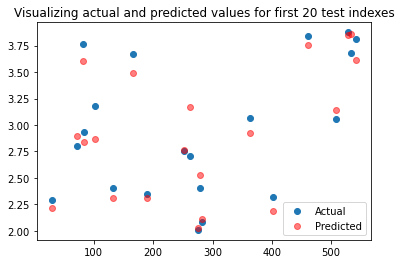

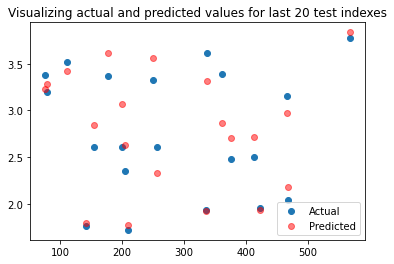

In [79]:
scatter_visualization(X_test, y_test, y_pred, 20)

In [80]:
# Making Function for the algorithm
def svr(X_train,y_train,test):
    svr = SVR()
    svr.fit(X_train, y_train)
    y_pred = svr.predict(test)
    return y_pred

# Linear regression model

In [107]:
# Analyzing Linear Regression Algorithm
lr1= LinearRegression()
lr1.fit(X_train, y_train)
y_pred = lr1.predict(X_test)
model1_score2_train= lr1.score(X_train, y_train)
model1_score2_test= lr1.score(X_test, y_test)
print('Training Score of Linear Regression Algorithm: ',model1_score2_train)
print('Testing Score of Linear Regression Algorithm: ',model1_score2_test)

Training Score of Linear Regression Algorithm:  0.8618931839459716
Testing Score of Linear Regression Algorithm:  0.8329068957333348


# Model 2

In [81]:
two_years_df.drop('Seat No.', axis=1, inplace=True)
features2 = two_years_df.drop('CGPA', axis=1)
target2 = two_years_df['CGPA']

In [82]:
features2.head()

,PH-121,HS-101,CY-105,HS-105/12,MT-111,CS-105,CS-106,EL-102,EE-119,ME-107,CS-107,HS-205/20,MT-222,EE-222,MT-224,CS-210,CS-211,CS-203,CS-214,EE-217,CS-212,CS-215
0,2.7,1.4,1.7,2.0,1.7,1.4,1.0,1.7,2.7,1.7,1.7,3.4,1.0,3.7,2.7,2.4,1.4,1.4,1.0,4.0,1.0,1.7
1,4.0,1.0,1.4,1.0,2.7,2.0,1.0,4.0,1.4,1.0,3.4,2.4,2.7,1.7,1.4,1.4,1.0,2.0,1.0,2.7,2.0,1.0
2,4.0,3.0,4.0,2.7,3.4,4.0,2.7,3.4,3.7,3.7,2.7,3.7,4.0,4.0,4.0,4.0,4.0,4.0,3.7,4.0,3.7,4.0
3,1.0,2.4,1.4,1.0,1.0,3.7,1.4,1.7,1.0,2.4,1.0,3.0,1.4,2.7,1.0,2.0,3.4,2.4,1.0,1.4,1.0,1.0
4,3.7,3.7,3.7,3.4,4.0,4.0,3.7,3.4,4.0,3.7,2.0,4.0,4.0,3.7,3.7,3.7,2.7,4.0,3.7,4.0,3.7,3.7


In [83]:
target2.head()

0    2.205
1    2.008
2    3.608
3    1.906
4    3.448
Name: CGPA, dtype: float64

In [84]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(features2, target2, test_size=0.2, random_state=42)

# Support Vector Regression

In [108]:
svr2 = SVR()
svr2.fit(X_train2, y_train2)
y_pred2 = svr2.predict(X_test2)
model2_score1_train= svr2.score(X_train2, y_train2)
model2_score1_test= svr2.score(X_test2, y_test2)
print('Training Score of  Algorithm: ',model2_score1_train)
print('Testing Score of  Algorithm: ',model2_score1_test)

Training Score of  Algorithm:  0.9808278781276563
Testing Score of  Algorithm:  0.9276443803294556


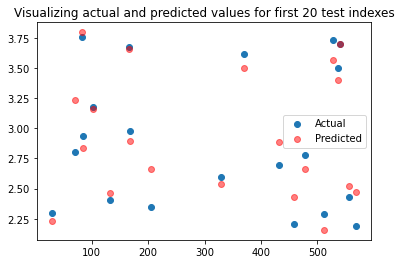

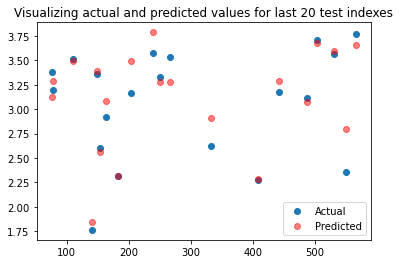

In [109]:
scatter_visualization(X_test2, y_test2, y_pred2, 20)

# Linear Regression Algorithm

In [110]:
# Analyzing Linear Regression Algorithm
lr2= LinearRegression()
lr2.fit(X_train2, y_train2)
y_pred2 = lr2.predict(X_test2)
model2_score2_train= lr2.score(X_train2, y_train2)
model2_score2_test= lr2.score(X_test2, y_test2)
print('Training Score of Linear Regression Algorithm: ',model2_score2_train)
print('Testing Score of Linear Regression Algorithm: ',model2_score2_test)

Training Score of Linear Regression Algorithm:  0.9222381501172631
Testing Score of Linear Regression Algorithm:  0.9070378072862816


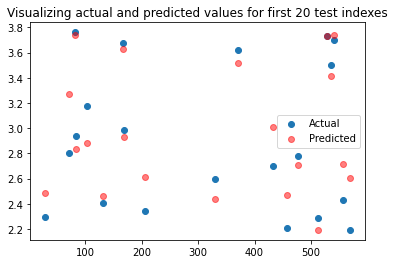

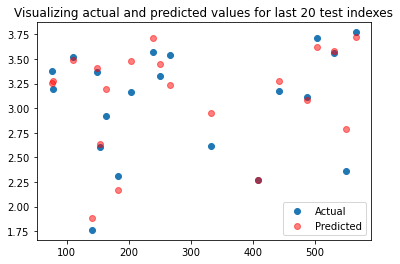

In [88]:
scatter_visualization(X_test2, y_test2, y_pred2, 20)

# Model 3

In [89]:
three_years.drop('Seat No.', axis=1, inplace=True)
features3 = three_years.drop('CGPA', axis=1)
target3 = three_years['CGPA']
features3.head()

,PH-121,HS-101,CY-105,HS-105/12,MT-111,CS-105,CS-106,EL-102,EE-119,ME-107,CS-107,HS-205/20,MT-222,EE-222,MT-224,CS-210,CS-211,CS-203,CS-214,EE-217,CS-212,CS-215,MT-331,EF-303,HS-304,CS-301,CS-302,TC-383,MT-442,EL-332,CS-318,CS-306,CS-312,CS-317,CS-403,CS-421,CS-406,CS-414,CS-419,CS-423,CS-412
0,2.7,1.4,1.7,2.0,1.7,1.4,1.0,1.7,2.7,1.7,1.7,3.4,1.0,3.7,2.7,2.4,1.4,1.4,1.0,4.0,1.0,1.7,2.0,1.7,2.4,3.0,2.0,2.4,3.4,2.0,1.7,2.0,1.7,1.7,1.7,1.7,3.7,4.0,1.7,3.0,3.7
1,4.0,1.0,1.4,1.0,2.7,2.0,1.0,4.0,1.4,1.0,3.4,2.4,2.7,1.7,1.4,1.4,1.0,2.0,1.0,2.7,2.0,1.0,1.4,1.0,1.7,3.7,1.4,1.7,1.7,2.0,3.7,1.0,1.4,1.0,2.0,1.0,3.7,2.7,2.0,2.0,3.0
2,4.0,3.0,4.0,2.7,3.4,4.0,2.7,3.4,3.7,3.7,2.7,3.7,4.0,4.0,4.0,4.0,4.0,4.0,3.7,4.0,3.7,4.0,4.0,2.4,4.0,3.4,3.7,3.0,4.0,3.4,3.7,3.7,3.0,3.0,4.0,2.0,4.0,4.0,4.0,3.7,4.0
3,1.0,2.4,1.4,1.0,1.0,3.7,1.4,1.7,1.0,2.4,1.0,3.0,1.4,2.7,1.0,2.0,3.4,2.4,1.0,1.4,1.0,1.0,1.4,1.0,2.7,1.0,2.7,1.4,1.7,1.4,3.4,1.7,1.4,2.0,1.4,1.7,2.7,3.0,2.4,2.4,2.4
4,3.7,3.7,3.7,3.4,4.0,4.0,3.7,3.4,4.0,3.7,2.0,4.0,4.0,3.7,3.7,3.7,2.7,4.0,3.7,4.0,3.7,3.7,2.4,1.7,3.7,2.7,3.7,2.4,3.7,3.7,2.7,3.7,2.7,3.4,3.4,2.7,3.7,4.0,3.7,3.7,4.0


In [90]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(features3, target3, test_size=0.2, random_state=42)

# Support Vector Regression

In [111]:
svr3 = SVR()
svr3.fit(X_train3, y_train3)
y_pred3 = svr3.predict(X_test3)
model3_score1_train= svr3.score(X_train3, y_train3)
model3_score1_test= svr3.score(X_test3, y_test3)
print('Training Score of  Algorithm: ',model3_score1_train)
print('Testing Score of  Algorithm: ',model3_score1_test)

Training Score of  Algorithm:  0.9886406523448943
Testing Score of  Algorithm:  0.9566206834648371


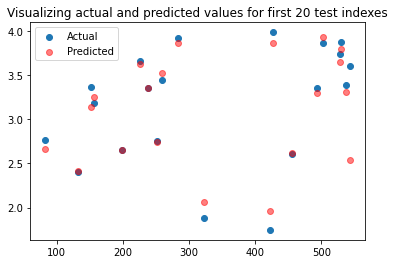

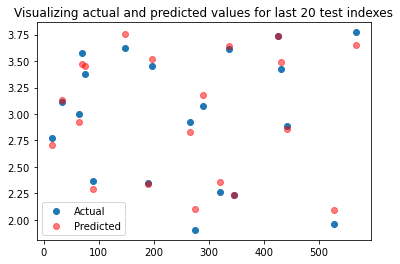

In [112]:
scatter_visualization(X_test3, y_test3, y_pred3, 20)

# Linear Regression Algorithm

In [113]:
# Analyzing Linear Regression Algorithm
lr3= LinearRegression()
lr3.fit(X_train3, y_train3)
model3_score2_train= lr3.score(X_train3, y_train3)
model3_score2_test= lr3.score(X_test3, y_test3)
print('Training Score of Linear Regression Algorithm: ',model3_score2_train)
print('Testing Score of Linear Regression Algorithm: ',model3_score2_test)
y_pred3 = lr3.predict(X_test3)

Training Score of Linear Regression Algorithm:  0.9764817928473186
Testing Score of Linear Regression Algorithm:  0.974743828299411


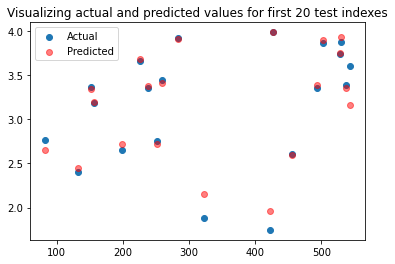

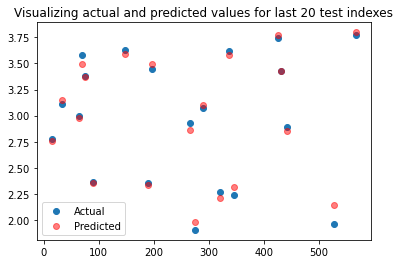

In [94]:
scatter_visualization(X_test3, y_test3, y_pred3, 20)

# Model 4

In [116]:

features4 = four_years.drop('CGPA', axis=1)
target4 = four_years['CGPA']
features4.head()

,PH-121,HS-101,CY-105,HS-105/12,MT-111,CS-105,CS-106,EL-102,EE-119,ME-107,CS-107,HS-205/20,MT-222,EE-222,MT-224,CS-210,CS-211,CS-203,CS-214,EE-217,CS-212,CS-215,MT-331,EF-303,HS-304,CS-301,CS-302,TC-383,MT-442,EL-332,CS-318,CS-306,CS-312,CS-317,CS-403,CS-421,CS-406,CS-414,CS-419,CS-423,CS-412
0,2.7,1.4,1.7,2.0,1.7,1.4,1.0,1.7,2.7,1.7,1.7,3.4,1.0,3.7,2.7,2.4,1.4,1.4,1.0,4.0,1.0,1.7,2.0,1.7,2.4,3.0,2.0,2.4,3.4,2.0,1.7,2.0,1.7,1.7,1.7,1.7,3.7,4.0,1.7,3.0,3.7
1,4.0,1.0,1.4,1.0,2.7,2.0,1.0,4.0,1.4,1.0,3.4,2.4,2.7,1.7,1.4,1.4,1.0,2.0,1.0,2.7,2.0,1.0,1.4,1.0,1.7,3.7,1.4,1.7,1.7,2.0,3.7,1.0,1.4,1.0,2.0,1.0,3.7,2.7,2.0,2.0,3.0
2,4.0,3.0,4.0,2.7,3.4,4.0,2.7,3.4,3.7,3.7,2.7,3.7,4.0,4.0,4.0,4.0,4.0,4.0,3.7,4.0,3.7,4.0,4.0,2.4,4.0,3.4,3.7,3.0,4.0,3.4,3.7,3.7,3.0,3.0,4.0,2.0,4.0,4.0,4.0,3.7,4.0
3,1.0,2.4,1.4,1.0,1.0,3.7,1.4,1.7,1.0,2.4,1.0,3.0,1.4,2.7,1.0,2.0,3.4,2.4,1.0,1.4,1.0,1.0,1.4,1.0,2.7,1.0,2.7,1.4,1.7,1.4,3.4,1.7,1.4,2.0,1.4,1.7,2.7,3.0,2.4,2.4,2.4
4,3.7,3.7,3.7,3.4,4.0,4.0,3.7,3.4,4.0,3.7,2.0,4.0,4.0,3.7,3.7,3.7,2.7,4.0,3.7,4.0,3.7,3.7,2.4,1.7,3.7,2.7,3.7,2.4,3.7,3.7,2.7,3.7,2.7,3.4,3.4,2.7,3.7,4.0,3.7,3.7,4.0


In [117]:
X_train4, X_test4, y_train4, y_test4 = train_test_split(features4, target4, test_size=0.2, random_state=42)

# Support Vector Regression

In [118]:
svr4 = SVR()
svr4.fit(X_train4, y_train4)
y_pred4 = svr4.predict(X_test4)
model4_score1_train= svr4.score(X_train4, y_train4)
model4_score1_test= svr4.score(X_test4, y_test4)
print('Training Score of  Algorithm: ',model4_score1_train)
print('Testing Score of  Algorithm: ',model4_score1_test)

Training Score of  Algorithm:  0.9886406523448943
Testing Score of  Algorithm:  0.9566206834648371


# Linear Regression Algorithm

In [119]:
# Analyzing Linear Regression Algorithm
lr4= LinearRegression()
lr4.fit(X_train4, y_train4)
model4_score2_train= lr4.score(X_train4, y_train4)
model4_score2_test= lr4.score(X_test4, y_test4)
print('Training Score of Linear Regression Algorithm: ',model4_score2_train)
print('Testing Score of Linear Regression Algorithm: ',model4_score2_test)
y_pred4 = lr4.predict(X_test4)

Training Score of Linear Regression Algorithm:  0.9764817928473186
Testing Score of Linear Regression Algorithm:  0.974743828299411


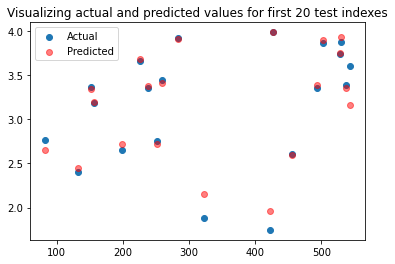

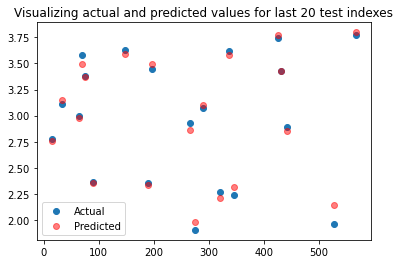

In [102]:
scatter_visualization(X_test4, y_test4, y_pred4, 20)

# Comparision of Model Scores

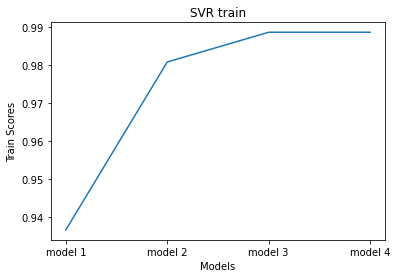

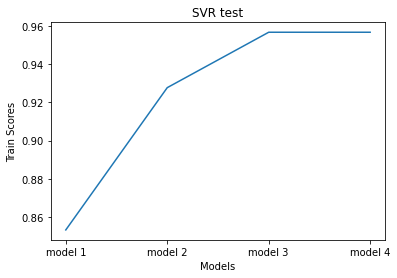

In [120]:
plt.plot(['model 1','model 2', 'model 3','model 4'],[model1_score1_train, model2_score1_train, model3_score1_train,model4_score1_train])
plt.title('SVR train')
plt.xlabel('Models')
plt.ylabel('Train Scores')
plt.show()
plt.plot(['model 1','model 2', 'model 3','model 4'],[model1_score1_test, model2_score1_test, model3_score1_test,model4_score1_test])
plt.title('SVR test')
plt.xlabel('Models')
plt.ylabel('Train Scores')
plt.show()

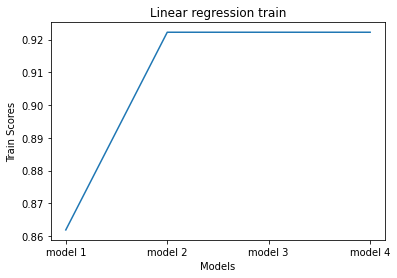

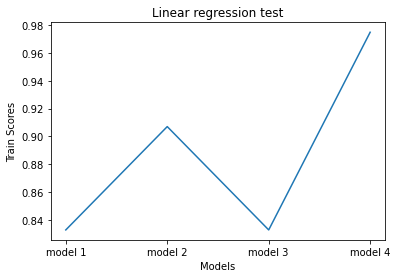

In [121]:
plt.plot(['model 1','model 2', 'model 3','model 4'],[model1_score2_train, model2_score2_train, model2_score2_train,model2_score2_train])
plt.title('Linear regression train')
plt.xlabel('Models')
plt.ylabel('Train Scores')
plt.show()
plt.plot(['model 1','model 2', 'model 3','model 4'],[model1_score2_test, model2_score2_test, model1_score2_test,model4_score2_test])
plt.title('Linear regression test')
plt.xlabel('Models')
plt.ylabel('Train Scores')
plt.show()